## Detection of monosynapic connections
A major advantage of single unit recordings is that we can detect if they are synaptically connected. There is a well-established procedure for assessing a single synaptic linkage from one neuron onto another, referred to as a monosynaptic connection. Polysynaptic connections, whereby one neuron influences another via a chain of synapses, is harder to detect if we have not recorded from the entire chain. However, if enough neurons are sampled from complex networks of connections can be uncovered and related back to what these neurons encode. This indicates how a microcircuit's structure implements function.

This tutorial covers the detection of monosynaptic connections and creation of a connection matrix.

In [1]:
import sys
import pynapple as nap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
sys.path.append('../code/') # for relative import in jupyter notebook
from fileio.loadphy import as_pynapple

### Load spiking data

In [2]:
phy_dir = '../test_data/phy/'
spks = as_pynapple(phy_dir)

### Calculate cross-correlation
To determine if a monosynaptic connection is present, we calculate the cross-correlation between single units. One of the units is designated the reference and the other the target. A histogram is constructed of the spike times from the target with respect to the spike times of the reference. If there is an excess of target spikes following a spike from the reference, this could indicate an excitatory synaptic connection.

The pynapple package provides an optimized algorithm for calculating cross-correlation functions.

In [3]:
bin_dur = 0.0005 # in seconds, 0.5 ms
win_dur = 0.01 # in seconds, 10 ms

cc_func = lambda x: nap.compute_crosscorrelogram(x,binsize=bin_dur,windowsize=win_dur,reverse=True)
spks_cc = cc_func(spks)

Pynapple returns the CC as a dataframe like object with each row a different time point, and each column a unique pair. A multilevel index is used for accessing the pairs. It is expressed as a tuple of 2 values, with form *(reference, target)*. Reference is the unit who spikes at time 0 ms, while target is the unit whose firing rate is being calculated relative to the spiking of the reference unit.

Here is how to pull out information from the cross-correlation object returned by pynapple:

In [4]:
# Get the time points of the CC
cc_tpts = spks_cc.index.values
print('The time points look like this:\n{}'.format(cc_tpts))

The time points look like this:
[-0.01   -0.0095 -0.009  -0.0085 -0.008  -0.0075 -0.007  -0.0065 -0.006
 -0.0055 -0.005  -0.0045 -0.004  -0.0035 -0.003  -0.0025 -0.002  -0.0015
 -0.001  -0.0005  0.      0.0005  0.001   0.0015  0.002   0.0025  0.003
  0.0035  0.004   0.0045  0.005   0.0055  0.006   0.0065  0.007   0.0075
  0.008   0.0085  0.009   0.0095  0.01  ]


In [5]:
# List all the pairs
cc_pairs = spks_cc.columns.values.tolist()
print('The pair tuples look like this:\n{}'.format(cc_pairs))

The pair tuples look like this:
[(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (14, 4), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (7, 6), (8, 6), (9, 6), (10, 6), (11, 6), (12, 6), (13, 6), (14, 6), (8, 7), (9, 7), (10, 7), (11, 7), (12, 7), (13, 7), (14, 7), (9, 8), (10, 8), (11, 8), (12, 8), (13, 8), (14, 8), (10, 9), (11, 9), (12, 9), (13, 9), (14, 9), (11, 10), (12, 10), (13, 10), (14, 10), (12, 11), (13, 11), (14, 11), (13, 12), (14, 12), (14, 13)]


In [6]:
# Get the CC from unit 3 to 6. 
# Unit 3 fires at 0 ms and change in firing rate of unit 6 is calculated relative to that
cc3to6 = spks_cc[(6,3)].values
print('The cross-correlogram looks like this:\n{}'.format(cc3to6))

The cross-correlogram looks like this:
[2.06602245 2.06602245 1.54329388 2.16558979 2.19048163 2.29004898
 1.39394286 1.56818571 1.89177959 2.06602245 1.66775306 1.94156326
 1.84199592 1.86688775 1.66775306 1.64286122 2.19048163 1.79221224
 2.19048163 2.06602245 2.11580612 2.31494081 3.88312653 4.35607142
 2.98702041 2.96212857 3.11147959 2.56385918 2.58875102 2.7132102
 2.46429183 1.9664551  2.31494081 2.36472449 2.2402653  1.81710408
 2.2402653  2.33983265 2.04113061 2.2402653  1.89177959]


### Examine CCs
Cross-correlation fuctions are often visualized as bar charts. Learning how to interpret these is an essential skill for an electrophysiologist.

In [7]:
# function to plot a cross-correlation
def cc_plot(cc, ax=None, labels=True): 
    # cc is a series selected from spks_cc, e.g. spks_cc[(0,1)] for the cc between unit 0 and 1
    t_pts = cc.index.values*1000
    cc_vals = cc.values
    dt = t_pts[1]-t_pts[0]
    if ax is None:
        fig, ax = plt.subplots()
    ax.grid()
    ax.bar(t_pts,cc_vals,width=dt,bottom=0)
    ax.set_xlim((t_pts[0],t_pts[-1]))
    ax.set_title(cc.name)
    if labels:
        ax.set_xlabel('Time from reference spike (ms)')
        ax.set_ylabel('Firing rate (Hz)')
    return ax

Here we will plot a few example pairs that highlight how to interpret CC.

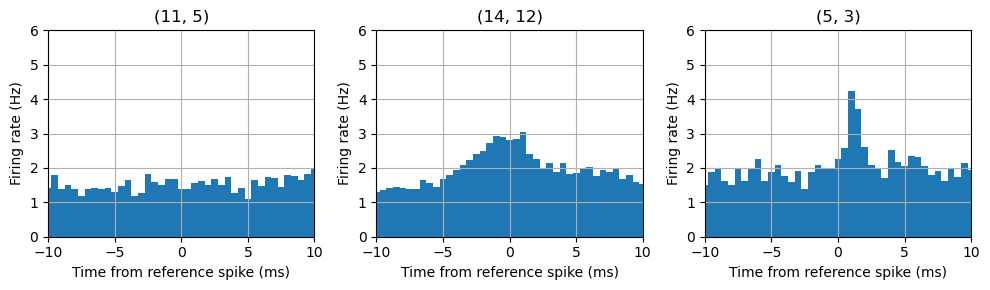

In [8]:
# Monosynaptic CCs vs non-monosynaptic CCs
fig, ax = plt.subplots(1,3)
cc_plot(spks_cc[(11,5)],ax=ax[0])
cc_plot(spks_cc[(14,12)],ax=ax[1])
cc_plot(spks_cc[(5,3)],ax=ax[2])
ax[0].set_ylim((0, 6))
ax[1].set_ylim((0, 6))
ax[2].set_ylim((0, 6))
fig.set_size_inches([10,3])
fig.tight_layout()
plt.show()

The first CC, (5,11), shows no correlated spiking between unit 5 and unit 11. The middle one shows an increase in correlated spiking between units 12 and 14, but it is relatively slow (several milliseconds) and centered at 0, which is suggestive that they have a large fraction of shared synaptic input. The last pair shows a monosynaptic connection from unit 5 to unit 3. You can see this because unit 5 tends to increase it firing rate for a brief moment (1 ms) 2 ms before unit 3 spikes at time 0 ms. This relationship is consistent with a synaptic connection.

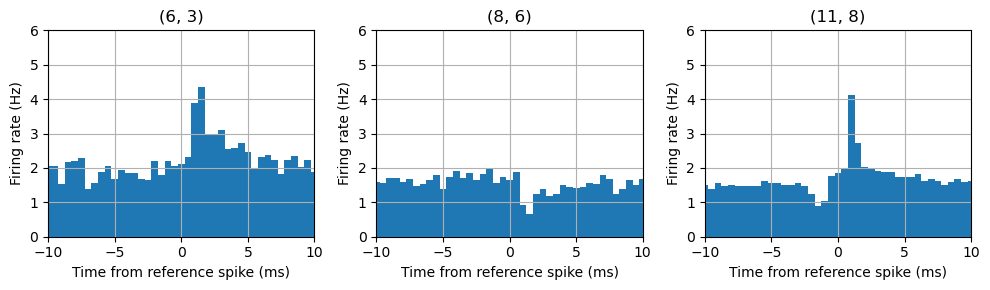

In [9]:
# Types of monosynaptic CC
fig, ax = plt.subplots(1,3)
cc_plot(spks_cc[(6,3)],ax=ax[0])
cc_plot(spks_cc[(8,6)],ax=ax[1])
cc_plot(spks_cc[(11,8)],ax=ax[2])
ax[0].set_ylim((0, 6))
ax[1].set_ylim((0, 6))
ax[2].set_ylim((0, 6))
fig.set_size_inches([10,3])
fig.tight_layout()
plt.show()

There are different kinds of monosynaptic CCs. The one on the left shows a monosynaptic excitatory connection from unit 6 to unit 3. The middle one is a monosynaptic inhibitory connection from unit 8 to unit 6. On the far right a more complicated one is shown, where unit 11 has a monosynaptic excitatory connection onto unit 8, and unit 8 delivers monosynaptic inhibition to unit 11. Thus, they are recurrently connected.

### Statistical testing of connections
A common, but computationally expensive, approach to testing the significance of monosynaptic CCs is to calculate surrogates using randomly jittered spike trains. To jitter, shift each spike in time by a random amount. If you jitter the spike times in a window of ~2 ms, calculate its CC with another unit, and repeat this thousands of times, you get a distribution of CCs that capture slow covarition in spiking activity, but eliminates fast interactions like those found between monosynaptically connected pairs. Using this distribution of CCs, you can measure the probability that the observed CC would have occured. If that probability is below some cutoff, say 0.01, then the CC is judged significant.

In [10]:
jit_max = 0.002 # in seconds, 2 ms
jit_num = 100 # number of jittered CCs to calculate 
cc_null_dist = np.zeros((*spks_cc.values.shape, jit_num))

for i in range(jit_num):
    # kept tsupport only because end of session is 'blank'
    spks_jit = nap.jitter_timestamps(spks, max_jitter=jit_max,keep_tsupport=True)
    spks_cc_jit = cc_func(spks_jit)
    cc_null_dist[:,:,i] = spks_cc_jit.values

null_ci = np.percentile(cc_null_dist,q=[0.5,50,99.5],axis=2)

In [11]:
# function to plot cross-correlation with null confidence intervals
def cc_ci_plot(cc, ci, **kwargs):
    curr_ci = null_ci[:,:,cc_pairs.index(cc.name)]
    t_pts = cc.index.values*1000
    ax = cc_plot(cc, **kwargs)
    ax.fill_between(t_pts,curr_ci[0,:],curr_ci[2,:],alpha=0.2,color='k')
    ax.plot(t_pts,curr_ci[1,:],color='k',linestyle=':')
    ax.plot(t_pts,curr_ci[0,:],color='b',alpha=0.7)
    ax.plot(t_pts,curr_ci[2,:],color='r',alpha=0.7)


Let's replot the CCs from above, but now with the confidence intervals for our surrogate distributions overlaid on top.

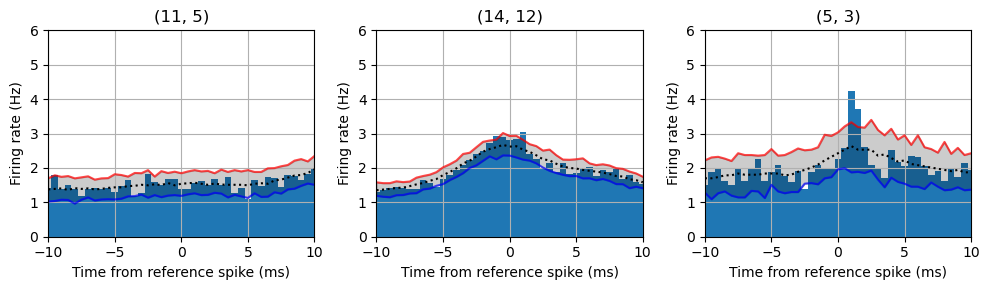

In [12]:
# Monosynaptic CCs vs non-monosynaptic CCs
fig, ax = plt.subplots(1,3)
cc_ci_plot(spks_cc[(11,5)],null_ci,ax=ax[0])
cc_ci_plot(spks_cc[(14,12)],null_ci,ax=ax[1])
cc_ci_plot(spks_cc[(5,3)],null_ci,ax=ax[2])
ax[0].set_ylim((0, 6))
ax[1].set_ylim((0, 6))
ax[2].set_ylim((0, 6))
fig.set_size_inches([10,3])
fig.tight_layout()
plt.show()


The surrogate distributions encompass the first two pairs that lack a monosynaptic connection. The third pair, however, has a prominent fast peak in its CC that exceeds the upper boundary of the surrogate distribution.

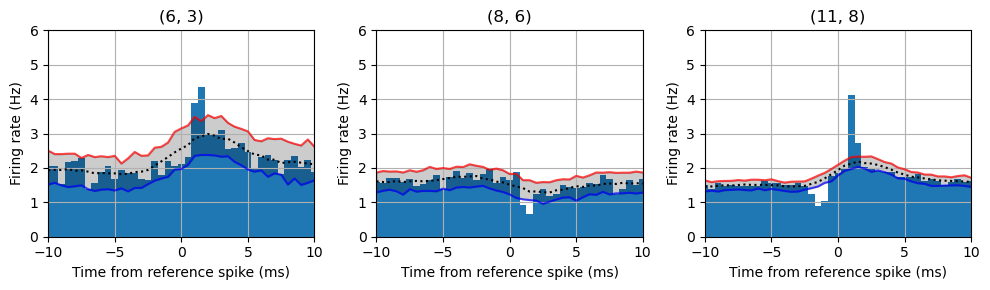

In [13]:
# Types of monosynaptic CC
fig, ax = plt.subplots(1,3)
cc_ci_plot(spks_cc[(6,3)],null_ci,ax=ax[0])
cc_ci_plot(spks_cc[(8,6)],null_ci,ax=ax[1])
cc_ci_plot(spks_cc[(11,8)],null_ci,ax=ax[2])
ax[0].set_ylim((0, 6))
ax[1].set_ylim((0, 6))
ax[2].set_ylim((0, 6))
fig.set_size_inches([10,3])
fig.tight_layout()
plt.show()

Each of these monosynaptic CCs substantially deviates from the null distribution. Notice that because the change in firing rate has a lower limit of 0, there will be a floor effect making it easier to detect an increase in firing (excitatory connection) over a decrease (inhibitory connection).

### Building a connection matrix
Checking each CC for significant deviations by eye would be tedius, especially if you have recordings with over 50 units (1225 pairs!). To automate this, we will write a simple algorithm to codify the features of a significant CC. These are:
1. Largest magnitude deviation from null is above or below CI line
2. Does not overlap with time 0 ms
3. Deviation lasts at least 1 ms and less than 4 ms

We will do this separately for the time bins that are positive and negative, with the positive time lags capturing connections in the direction of reference -> target, and negative time lags the target -> reference direction.

In [14]:
# determine if CC is significant and its weight
def cc_sig(cc_vals, cc_ci):
    # cc_vals is half the cc (pos or neg lag side), and always starts at 0 lag
    # cc_ci is the lower, middle, and upper null percentiles for the corresponding cc_vals
    cc_dev = cc_vals-cc_ci[1,:]
    max_ind = np.argmax(np.abs(cc_dev))

    # determine if maximal deviation is significant
    if cc_vals[max_ind]>cc_ci[2,max_ind]:
        cc_dev_sig = (cc_vals-cc_ci[2,:])>0
    elif cc_vals[max_ind]<cc_ci[0,max_ind]:
        cc_dev_sig = (cc_vals-cc_ci[0,:])<0
    else:
        return 0 # exit if max deviation is within null CI

    # determine if maximal deviation does not overlap zero lag and is long enough
    # get left edge of significant region
    l_edge = max_ind
    for x in range(max_ind,0,-1):
        l_edge = x
        if not cc_dev_sig[x-1]:
            break
    
    # get right edge of significant region
    r_edge = max_ind
    for x in range(max_ind,cc_vals.size-1):
        r_edge = x
        if not cc_dev_sig[x+1]:
            break
    
    # if sig peak overlaps with 0 time lag, then no connection
    if l_edge == 0:
        return 0

    
    # if sig peak is shorter than 1ms or longer than 4 ms, then no connection
    peak_dur = ((r_edge-l_edge)+1)*bin_dur
    if (peak_dur<0.001) or (peak_dur>0.004):
        return 0
    
    # connection passed all tests and is significant, return weight
    return 100*cc_dev[max_ind]/cc_ci[1,max_ind]


In [15]:
# create connection matrix
num_units = len(spks)
conn_mat = np.zeros((num_units,num_units))

for ind, pair in enumerate(cc_pairs):
    curr_ci = null_ci[:,:,ind]
    curr_cc = spks_cc[pair]
    z_lag_ind = np.argmin(np.abs(curr_cc.index.values)) # found closest to zero in case lag not exactly zero

    # evaluate positive lag, reference -> target
    conn_mat[pair[0],pair[1]] = cc_sig(curr_cc.values[z_lag_ind:], curr_ci[:,z_lag_ind:])

    # evaluate negative lag, target -> reference
    conn_mat[pair[1],pair[0]] = cc_sig(curr_cc.values[z_lag_ind::-1], curr_ci[:,z_lag_ind::-1])

Now we can plot the connection matrix.

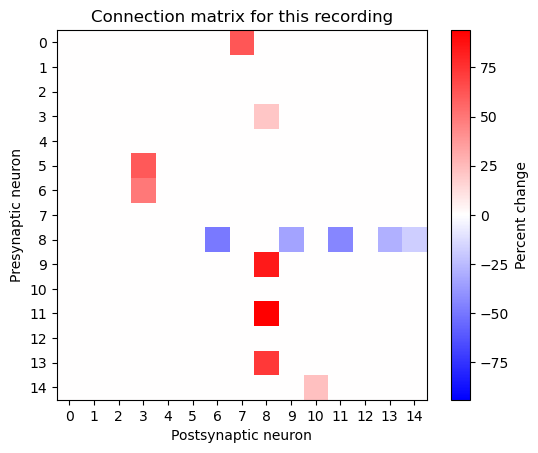

In [16]:
fig, ax = plt.subplots()
imh = ax.imshow(conn_mat,cmap='bwr',norm=colors.CenteredNorm())
fig.colorbar(imh, label='Percent change')
ax.set_xticks(np.arange(num_units))
ax.set_yticks(np.arange(num_units))
ax.set_xlabel('Postsynaptic neuron')
ax.set_ylabel('Presynaptic neuron')
ax.set_title('Connection matrix for this recording')
ax.set_aspect('equal')
plt.show()

A few aspects of the network stand out from this plot. We can see that Unit 8 is an inhibitory interneuron, because all of its outgoing connections are inhibitory (row 8 is blue for all connections). It also receives several strong excitatory connections, mainly with neurons that it inhibits. The other neurons in the network tend to be sparsely connected with excitatory synapses. These features of the connectivity are consistent with our knowledge of cortical circuit wiring.